In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from IPython.display import display
from PIL import Image

print (tf.__version__)

1.0.0


In [39]:
import vgg16

vgg16.maybe_download()

- Download progress: 100.0%
Download finished. Extracting files.
Done.


In [40]:
# Error between 2 sensors
# Pehle difference lo => a - b, outputs a tensor of differences
# Then make the differences positive by squaring them => tf.square(a-b) => A tensor of squares
# Then take mean of squared values, returns a SCALAR, mind you a SCALAR, which is essentially the average of values

def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

# Ab content loss create karte hn
VGG lagao on content_image as well as on mixed image
Now suppose layers of interest are last 5 layers, layer 11-16.
So take squared mean error of "tensor of layer 11 VGG on content image" and "tensor of layer 11 VGG on mixed image"

In [41]:
def create_content_loss (session, model, content_image, layer_ids):
    # Creating a feed dictionary with content image
    feed_dict = model.create_feed_dict (image = content_image)
    
    # We don't need to create loss from all layers..
    # For content, the more desirable layers are the ones which are high level ones.
    # In VGG16, the intital level layers are mere contours or edges of the image
    # HOWEVER, THE UPPER LAYERS ARE MORE ABSTRACT LIKE FACE.. 
    # We need to compare content image with those HIGH LEVEL layers of VGG
    # Now which layer among the high level ones is still experimental
    layers = model.get_layer_tensors(layer_ids)

    # Calculate the output values of those layers when
    # feeding the content-image to the model.
    values = session.run(layers, feed_dict=feed_dict)
    
    with model.graph.as_default():
        # Initialize an empty list of loss-functions.
        # because we are calculating losses per layer
        layer_losses = []
        
        for value, layer in zip(values, layers):
            loss = mean_squared_error(layer, value)
            
            # Add the loss-function for this layer to the
            # list of loss-functions.
            layer_losses.append(loss)
            
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

# Style loss k liye we need a helper function, which generates gram matrix
We will do something similar for the style-layers, but now we want to measure which features in the style-layers activate simultaneously for the style-image, and then copy this activation-pattern to the mixed-image.
One way of doing this, is to calculate the so-called Gram-matrix for the tensors output by the style-layers. 

The Gram-matrix is essentially just a matrix of dot-products for the vectors of the feature activations of a style-layer.


If an entry in the Gram-matrix has a value close to zero then it means the two features in the given layer do not activate simultaneously for the given style-image. And vice versa, if an entry in the Gram-matrix has a large value, then it means the two features do activate simultaneously for the given style-image. We will then try and create a mixed-image that replicates this activation pattern of the style-image.

In [42]:
def gram_matrix(tensor):
    
    # It's a 4-D tensor that we are getting from convolution layer
    shape = tensor.get_shape()
    
    # Number of feature channels, kind of like R,G,B => 3 channels
    num_channels = int(shape[3])
    
    #-1 means whatever number makes the data fit 
    # Reshape the tensor so it is a 2-dim matrix. This essentially
    # flattens the contents of each feature-channel.
    matrix = tf.reshape(tensor=tensor, shape=[-1, num_channels])
    
    #gram matrix is transpose matrix with itself
    #so each entry in gram matrix
    #tells us if a feature channel has a tendency
    #to be activated with another feature channel
    gram = tf.matmul(tf.transpose(matrix), matrix)
    
    return gram

In [43]:
# Model here will be an instance of the VGG16-class.
def create_style_loss(session, model, style_image, layer_ids):
    feed_dict = model.create_feed_dict (image=style_image)
    
    layers = model.get_layer_tensors (layer_ids)
    
    with model.graph.as_default():
        layer_losses = []
        
        gram_layers = [gram_matrix(layer) for layer in layers]
        
        values = session.run(gram_layers, feed_dict=feed_dict)
        
        for value, gram_layer in zip(values, gram_layers):
            value_const = tf.constant(value)
            
            loss = mean_squared_error(gram_layer, value_const)
            
            layer_losses.append(loss)
        
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

This creates the loss-function for denoising the mixed-image. The algorithm is called Total Variation Denoising and essentially just shifts the image one pixel in the x- and y-axis, calculates the difference from the original image, takes the absolute value to ensure the difference is a positive number, and sums over all the pixels in the image. This creates a loss-function that can be minimized so as to suppress some of the noise in the image.

In [44]:
#shifts input image by 1 pixel on x and y axis 
#calculate difference between shifted and original image
#absolute value to make positive
#calculate sum of pixels in those images
#helps suppress noise in mixed image we are generating



def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [66]:
#relative weights - normalized.
#style should have more weight than content
def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content=1.5, weight_style=10.0,
                   weight_denoise=0.3,
                   num_iterations=120, step_size=10.0):
    """
    Use gradient descent to find an image that minimizes the
    loss-functions of the content-layers and style-layers. This
    should result in a mixed-image that resembles the contours
    of the content-image, and resembles the colours and textures
    of the style-image.
    
    Parameters:
    content_image: Numpy 3-dim float-array with the content-image.
    style_image: Numpy 3-dim float-array with the style-image.
    content_layer_ids: List of integers identifying the content-layers.
    style_layer_ids: List of integers identifying the style-layers.
    weight_content: Weight for the content-loss-function.
    weight_style: Weight for the style-loss-function.
    weight_denoise: Weight for the denoising-loss-function.
    num_iterations: Number of optimization iterations to perform.
    step_size: Step-size for the gradient in each iteration.
    """

    # Create an instance of the VGG16-model. This is done
    # in each call of this function, because we will add
    # operations to the graph so it can grow very large
    # and run out of RAM if we keep using the same instance.
    model = vgg16.VGG16()

    # Create a TensorFlow-session.
    session = tf.InteractiveSession(graph=model.graph)

    # Print the names of the content-layers.
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # Print the names of the style-layers.
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # Create the loss-function for the content-layers and -image.
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # Create the loss-function for the style-layers and -image.
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # Create the loss-function for the denoising of the mixed-image.
    loss_denoise = create_denoise_loss(model)

    
    #adjust levels of loss functions, normalize them
    #multiply them with a variable
    #taking reciprocal values of loss values of content, style, denoising
    #small constant to avoid divide by 0
    #adjustment value normalizes loss so approximately 1
    #weights should be set relative to each other dont depend on layers
    #we are using
    
    # Create TensorFlow variables for adjusting the values of
    # the loss-functions. This is explained below.
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # Initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # Create TensorFlow operations for updating the adjustment values.
    # These are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # This is the weighted loss-function that we will minimize
    # below in order to generate the mixed-image.
    # Because we multiply the loss-values with their reciprocal
    # adjustment values, we can use relative weights for the
    # loss-functions that are easier to select, as they are
    # independent of the exact choice of style- and content-layers.
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # Use TensorFlow to get the mathematical function for the
    # gradient of the combined loss-function with regard to
    # the input image. (mixed)
    gradient = tf.gradients(loss_combined, model.input)

    # List of tensors that we will run in each optimization iteration.
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # The mixed-image is initialized with random noise.
    # It is the same size as the content-image.
    #where we first init it
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        # Create a feed-dict with the mixed-image.
        feed_dict = model.create_feed_dict(image=mixed_image)

        # Use TensorFlow to calculate the value of the
        # gradient, as well as updating the adjustment values.
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # Reduce the dimensionality of the gradient.
        #Remove single-dimensional entries from the shape of an array.
        grad = np.squeeze(grad)

        # Scale the step-size according to the gradient-values.
        #Ratio of weights:updates
        #akin to learning rate
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # Update the image by following the gradient.
        #gradient descent
        mixed_image -= grad * step_size_scaled

        # Ensure the image has valid pixel-values between 0 and 255.
        #Given an interval, values outside the interval are clipped 
        #to the interval edges.
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # Print a little progress-indicator.
        print(". ", end="")

        # Display status once every 10 iterations, and the last.
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # Print adjustment weights for loss-functions.
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            #in larger resolution
            # Plot the content-, style- and mixed-images.
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)
    save_image(image=mixed_image, filename='output.jpg')

    # Close the TensorFlow session to release its resources.
    session.close()
    
    # Return the mixed-image.
    return mixed_image

In [67]:
def load_image(filename, max_size=None):
    image = Image.open(filename)

    if max_size is not None:
        # Calculate the appropriate rescale-factor for
        # ensuring a max height and width, while keeping
        # the proportion between them.
        factor = max_size / np.max(image.size)
    
        # Scale the image's height and width.
        size = np.array(image.size) * factor

        # The size is now floating-point because it was scaled.
        # But PIL requires the size to be integers.
        size = size.astype(int)

        # Resize the image.
        image = image.resize(size, Image.LANCZOS)

    # Convert to numpy floating-point array.
    return np.float32(image)

In [68]:
def save_image(image, filename):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    with open(filename, 'wb') as file:
        Image.fromarray(image).save(file, 'jpeg')

In [69]:
def plot_image_big(image):
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # Convert pixels to bytes.
    image = image.astype(np.uint8)

    # Convert to a PIL-image and display it.
    display(Image.fromarray(image))

In [70]:
def plot_images(content_image, style_image, mixed_image):
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [92]:
content_filename = 'input.jpg'
content_image = load_image(content_filename, max_size=None)

In [93]:
style_filename = 'style2.jpg'
style_image = load_image(style_filename, max_size=300)

In [78]:
content_layer_ids = [4]

In [79]:
# The VGG16-model has 13 convolutional layers.
# This selects all those layers as the style-layers.
# This is somewhat slow to optimize.
style_layer_ids = list(range(13))

# You can also select a sub-set of the layers, e.g. like this:
# style_layer_ids = [1, 2, 3, 4]

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.43e-11, Style: 2.84e-29, Denoise: 2.10e-06


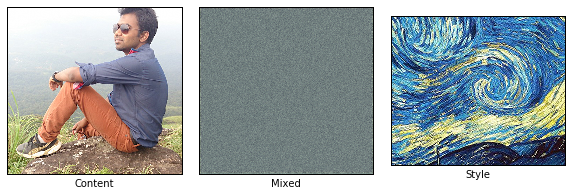

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 1.02e-10, Style: 2.16e-28, Denoise: 5.85e-08


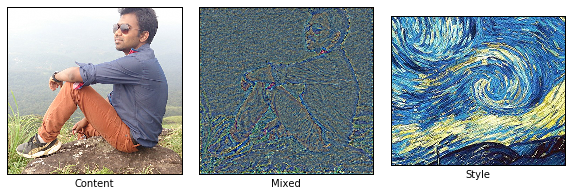

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 1.09e-10, Style: 4.10e-28, Denoise: 5.18e-08


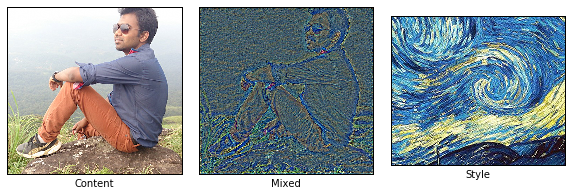

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 1.11e-10, Style: 6.80e-28, Denoise: 4.70e-08


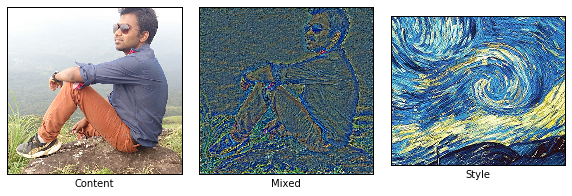

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 1.16e-10, Style: 1.08e-27, Denoise: 4.35e-08


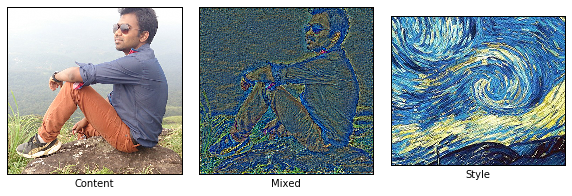

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 1.22e-10, Style: 1.44e-27, Denoise: 4.17e-08


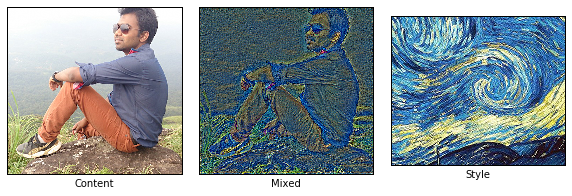

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 8.92e-11, Style: 1.17e-28, Denoise: 2.92e-08


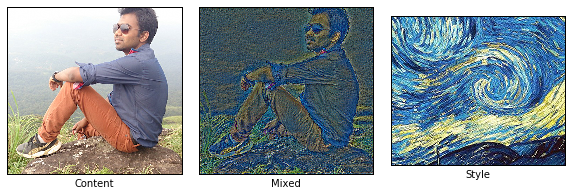


Final image:


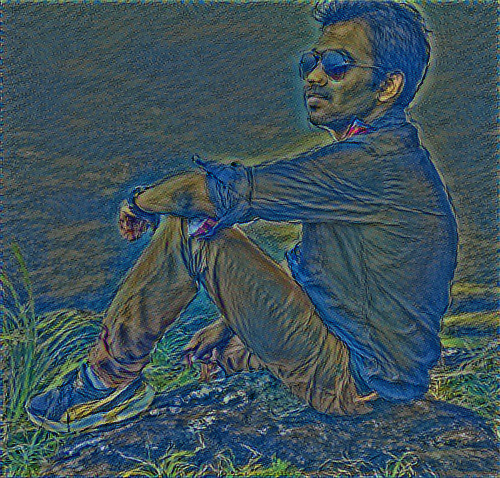

CPU times: user 36min 28s, sys: 3min 2s, total: 39min 31s
Wall time: 11min 19s


In [94]:
%%time
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=8.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)